<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/initial_dataprocessing_stockvalue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb

In [3]:
%%capture
!cd npmf && git pull

In [4]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [28]:
import os
from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3

In [60]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (8, 6)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
np.random.seed(420)

# Let's get the data and and check it 😂✨KAWAIII ^^✨



In [9]:
def get_df_artifact(name):
    with wb.init(project="master-test") as run:
        art = run.use_artifact(name)
        art.download()
        filepath = art.file()

        return pd.read_feather(filepath)

In [10]:
data = get_df_artifact("oil-company-data:v1").set_index("Instrument")

wandb: Currently logged in as: krankile (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact oil-company-data:v1, 461.61MB. 1 files... Done. 0:0:0


In [11]:
data = data[~(data.Date == "")].astype({"Date": np.datetime64})
data

,Date,Company Market Cap,Price Close,Currency
Instrument,,,,
GGX.AX,2005-05-13,4510832.105479,0.116764,USD
GGX.AX,2005-05-16,4486502.643904,0.116764,USD
GGX.AX,2005-05-17,4483522.209137,0.116057,USD
GGX.AX,2005-05-18,4519172.59536,0.116057,USD
GGX.AX,2005-05-19,3827143.993207,0.099066,USD
...,...,...,...,...
AEC.V,2022-04-14,43250854.906096,0.10716,USD
AEC.V,2022-04-18,43082857.134364,0.107015,USD
AEC.V,2022-04-19,43079442.196417,0.107015,USD


### Number of unique companies

In [12]:
tickers = data[~data["Company Market Cap"].isna()].index.unique()

print(f"{tickers.shape[0]} unique companies in the set")

1697 unique companies in the set


### Number of datapoints for the market cap

In [13]:
marketcaps = data.shape[0]
print(f"There is a total of {marketcaps} datapoints in the dataset")

marketcaps = data[~data["Company Market Cap"].isna()].shape[0]
print(f"There is a total of {marketcaps} datapoints in the dataset that are not NAs")

There is a total of 6230549 datapoints in the dataset
There is a total of 6117652 datapoints in the dataset that are not NAs


## Start process of sorting out data

First, cut of leading and trailing NAs for all companies.

### Remove leading and trailing NAs

In [14]:
stripped = []
points_stripped = 0

for ticker in tqdm(tickers):
    d = data.loc[ticker, ]
    start = 0
    end = d.shape[0]

    # Start at the beginning and find first real value
    for i, val in enumerate(d["Company Market Cap"]):
        if not pd.isna(val):
            start = i
            break
    points_stripped += i

    for i, val in enumerate(d["Company Market Cap"][::-1]):
        if not pd.isna(val):
            end -= i
            break
    points_stripped += i

    stripped.append(d.iloc[start:end, ])

stripped = pd.concat(stripped, axis=0)

print(f"Total of {stripped.shape[0]} datapoints after stripping")

100%|██████████| 1697/1697 [03:58<00:00,  7.13it/s]


Total of 6169474 datapoints after stripping


Then, consider different strategies for sorting out companies. For example

1.   Make sure companies have less than $p$% NAs for all quarters
2.   Take out companies where each string of missing values are longer than $n$

### Remove companies with long streaks of NAs

In [16]:
def na_streak_maxlen(ser):

    longest = 0
    curr = 0

    for val in ser:
        if not pd.isna(val):
            curr = 0
            continue
        
        curr += 1

        if curr > longest:
            longest = curr

    return longest

In [25]:
s = pd.Series([1, 2, 3, pd.NA, pd.NA, pd.NA, 1, pd.NA, pd.NA, 5, 6, 7])
na_streak_maxlen(s)

3

In [26]:
longest_gap = dict()

for ticker in tqdm(tickers):
    longest_gap[ticker] = na_streak_maxlen(stripped.loc[ticker, "Company Market Cap"])

100%|██████████| 1697/1697 [03:45<00:00,  7.54it/s]


In [39]:
counts = stripped.reset_index().groupby("Instrument").count()
points = dict(zip(counts.index, counts["Company Market Cap"]))

In [53]:
ks = sorted(set(longest_gap.values()))

runtot_comp = 0
runtot_data = 0
left = set(tickers)

companies = []
datapoints = []

for k in tqdm(ks):
    for ticker in left.copy():
        if longest_gap[ticker] <= k:
            runtot_comp += 1
            runtot_data += points[ticker]
            left.remove(ticker)

    companies.append(runtot_comp)
    datapoints.append(runtot_data)

100%|██████████| 102/102 [00:00<00:00, 10448.63it/s]


In [77]:
np.array(datapoints) / sum(points.values())

array([0.93656946, 0.93749301, 0.9383538 , 0.93927703, 0.93954053,
       0.94042077, 0.9413422 , 0.94193328, 0.94264384, 0.94340361,
       0.94382355, 0.94470509, 0.94504264, 0.94561083, 0.94619815,
       0.94680639, 0.94729089, 0.94797367, 0.94851195, 0.94911005,
       0.94945299, 0.95030659, 0.95057205, 0.95112112, 0.9514567 ,
       0.95209486, 0.95299504, 0.95389506, 0.95561189, 0.95626868,
       0.95691321, 0.95824934, 0.95875051, 0.95961294, 0.95981579,
       0.96045705, 0.96062362, 0.96143994, 0.96233228, 0.96309761,
       0.96395186, 0.96481117, 0.96537152, 0.96623067, 0.96667251,
       0.96720556, 0.96814366, 0.96884262, 0.96968249, 0.97053428,
       0.97115985, 0.9728914 , 0.97365166, 0.97453386, 0.97504206,
       0.97568217, 0.97647235, 0.97686547, 0.97724944, 0.9776169 ,
       0.97848325, 0.9789192 , 0.9794735 , 0.97971885, 0.98054907,
       0.98106332, 0.98156106, 0.98196628, 0.98258155, 0.98336911,
       0.98350871, 0.98393272, 0.98474317, 0.98555214, 0.98614

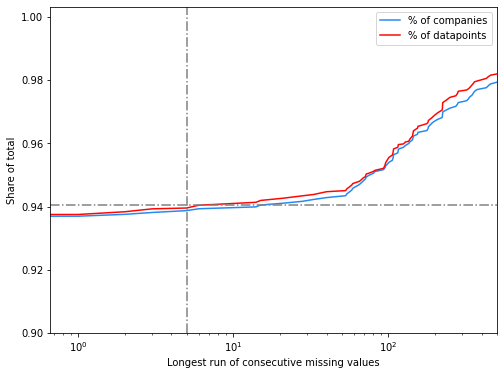

In [88]:
total_comp = stripped.index.unique().shape[0]
total_points = sum(points.values())

c = np.array(companies) / total_comp
d = np.array(datapoints) / total_points

plt.plot(ks, c, label="% of companies")
plt.plot(ks, d, label="% of datapoints")

plt.xscale("log")
plt.ylim(bottom=0.9)
plt.xlim(right=500)
plt.xlabel("Longest run of consecutive missing values")
plt.ylabel("Share of total")
plt.axhline(y=0.94042077, color="gray", linestyle="-.")
plt.axvline(x=5, color="gray", linestyle="-.")
plt.legend();